# Random Forest Regression in Neuroscience

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import cross_val_score, cross_val_predict,ShuffleSplit
from scipy.stats import pearsonr
from fancyimpute import KNN

In [4]:
plt.rcParams.update({'font.size':16,'figure.figsize':(12,8)})

## Loading data from NeuroElectro

In [5]:
df = pd.read_csv('data/article_ephys_metadata_curated.csv',delimiter='\t').set_index('Index')
df.head(3)

,Title,Pmid,PubYear,LastAuthor,ArticleID,TableID,NeuronName,NeuronLongName,NeuronPrefName,NeuroNERAnnots,...,sahpvolt_err,sahpvolt_n,sahpvolt_sd,sahpvolt_note,mahpvolt,mahpvolt_raw,mahpvolt_err,mahpvolt_n,mahpvolt_sd,mahpvolt_note
Index,,,,,,,,,,,,,,,,,,,,,
150,Cell type-specific effects of adenosine on cor...,24108800,2015,Feldmeyer D,88449,35984.0,Neocortex basket cell,medial prefrontal cortex fast spiking interne...,medial prefrontal cortex fast spiking interne...,"[ABA_REGION:714, HBP_EPHYS:0000080, HBP_EPHYS_...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,Cell type-specific effects of adenosine on cor...,24108800,2015,Feldmeyer D,88449,35984.0,Neocortex Martinotti cell,medial prefrontal cortex low-threshold spiking...,medial prefrontal cortex low-threshold spiking...,"[ABA_REGION:714, HBP_EPHYS:0000110, HBP_EPHYS_...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,Cell type-specific effects of adenosine on cor...,24108800,2015,Feldmeyer D,88449,35984.0,Neocortex basket cell,somatosensory cortex fast-firing interneuron,somatosensory cortex fast-firing interneuron,"[ABA_REGION:453, HBP_EPHYS:0000080, HBP_EPHYS_...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## To make this easier, let's restruct the data to only that from one cell type

In [6]:
df = df[df['NeuronName'].isin(['Hippocampus CA1 pyramidal cell'])]
df.head()

,Title,Pmid,PubYear,LastAuthor,ArticleID,TableID,NeuronName,NeuronLongName,NeuronPrefName,NeuroNERAnnots,...,sahpvolt_err,sahpvolt_n,sahpvolt_sd,sahpvolt_note,mahpvolt,mahpvolt_raw,mahpvolt_err,mahpvolt_n,mahpvolt_sd,mahpvolt_note
Index,,,,,,,,,,,,,,,,,,,,,
721,Hippocampal function is compromised in an anim...,25795599,2015,Manahan-Vaughan D,92518,47576.0,Hippocampus CA1 pyramidal cell,Hippocampus CA1 stratum radiatum pyramidal imm...,Hippocampus CA1 stratum radiatum pyramidal imm...,"[ABA_REGION:382, UNKN_REGION:1407, HBP_MORPHOL...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
722,Hippocampal function is compromised in an anim...,25795599,2015,Manahan-Vaughan D,92518,47576.0,Hippocampus CA1 pyramidal cell,Hippocampus CA1 stratum radiatum pyramidal imm...,Hippocampus CA1 stratum radiatum pyramidal imm...,"[ABA_REGION:382, UNKN_REGION:1407, HBP_MORPHOL...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1371,Tau-dependent Kv4.2 depletion and dendritic hy...,25878292,2015,Roberson ED,92084,46519.0,Hippocampus CA1 pyramidal cell,NaN,Hippocampus CA1 pyramidal cell,"[ABA_REGION:382, HBP_MORPHOLOGY:0000001, Neuro...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202,Reversal of Aging-Related Neuronal Ca2+ Dysreg...,26224869,2015,Landfield PW,92396,47312.0,Hippocampus CA1 pyramidal cell,NaN,Hippocampus CA1 pyramidal cell,"[ABA_REGION:382, HBP_MORPHOLOGY:0000001, Neuro...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1203,Reversal of Aging-Related Neuronal Ca2+ Dysreg...,26224869,2015,Landfield PW,92396,47312.0,Hippocampus CA1 pyramidal cell,NaN,Hippocampus CA1 pyramidal cell,"[ABA_REGION:382, HBP_MORPHOLOGY:0000001, Neuro...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## There are so many variables to choose from!  

In [7]:
print(list(df))

['Title', 'Pmid', 'PubYear', 'LastAuthor', 'ArticleID', 'TableID', 'NeuronName', 'NeuronLongName', 'NeuronPrefName', 'NeuroNERAnnots', 'BrainRegion', 'MetadataCurated', 'Species', 'Strain', 'ElectrodeType', 'PrepType', 'JxnPotential', 'JxnOffset', 'RecTemp', 'AnimalAge', 'AnimalWeight', 'FlagSoln', 'ExternalSolution', 'ExternalSolution_conf', 'external_0_Mg', 'external_0_Ca', 'external_0_Na', 'external_0_Cl', 'external_0_K', 'external_0_pH', 'InternalSolution', 'InternalSolution_conf', 'internal_0_Mg', 'internal_0_Ca', 'internal_0_Na', 'internal_0_Cl', 'internal_0_K', 'internal_0_pH', 'MetadataNote', 'TableNote', 'rin', 'rin_raw', 'rin_err', 'rin_n', 'rin_sd', 'rin_note', 'rmp', 'rmp_raw', 'rmp_err', 'rmp_n', 'rmp_sd', 'rmp_note', 'apthr', 'apthr_raw', 'apthr_err', 'apthr_n', 'apthr_sd', 'apthr_note', 'apamp', 'apamp_raw', 'apamp_err', 'apamp_n', 'apamp_sd', 'apamp_note', 'aphw', 'aphw_raw', 'aphw_err', 'aphw_n', 'aphw_sd', 'aphw_note', 'tau', 'tau_raw', 'tau_err', 'tau_n', 'tau_sd', '

## Choose some variables/features to model and pick one of them to be the prediction target

In [8]:
target = 'apamp' # Height of action potentials

features = ['PubYear','Species','Strain','ElectrodeType',
            'PrepType','JxnPotential','JxnOffset','RecTemp','AnimalAge','AnimalWeight',
            'ExternalSolution_conf',
            'external_0_Mg','external_0_Ca','external_0_Na','external_0_Cl','external_0_K',
            'external_0_pH','InternalSolution_conf','internal_0_Mg',
            'internal_0_Ca','internal_0_Na','internal_0_Cl','internal_0_K','internal_0_pH']

## When "bad" (NaN, Inf, poorly encoded) values are in the variable to be predicted, we don't want to impute (guess) what they should be.  

## Instead, just drop them

In [9]:
df = df[df[target].notnull()]

## Apply the One Hot Encoding (from last week)

In [10]:
df_predictors = pd.get_dummies(df[features]) # Turns categorical data into yes/no data
df_predictors.head()

,PubYear,JxnOffset,RecTemp,AnimalAge,AnimalWeight,ExternalSolution_conf,external_0_Mg,external_0_Ca,external_0_Na,external_0_Cl,...,"ElectrodeType_Patch-clamp, Sharp","ElectrodeType_Perforated patch, Patch-clamp",ElectrodeType_Sharp,PrepType_cell culture,PrepType_in vitro,"PrepType_in vitro, cell culture",PrepType_in vivo,JxnPotential_Corrected,JxnPotential_Not corrected,JxnPotential_Unreported
Index,,,,,,,,,,,,,,,,,,,,,
721,2015,NaN,23.0,16.309506,NaN,5.0,1.3,2.5,149.60,133.9,...,0,0,0,0,1,0,0,0,0,1
722,2015,NaN,23.0,42.426407,NaN,5.0,1.3,2.5,149.60,133.9,...,0,0,0,0,1,0,0,0,0,1
1371,2015,NaN,31.0,NaN,NaN,5.0,1.0,2.0,151.25,133.5,...,0,0,0,0,1,0,0,0,0,1
1202,2015,NaN,22.0,134.164079,NaN,5.0,2.0,2.0,154.00,139.0,...,0,0,1,0,0,0,1,0,0,1
1203,2015,NaN,22.0,629.285309,NaN,5.0,2.0,2.0,154.00,139.0,...,0,0,1,0,0,0,1,0,0,1


## Impute Missing Values for the predictors (not the target)

In [11]:
from fancyimpute import KNN
df_predictors[:] = KNN(k=3).complete(df_predictors.values)
df_predictors.head(3)

Imputing row 1/74 with 3 missing, elapsed time: 0.002


,PubYear,JxnOffset,RecTemp,AnimalAge,AnimalWeight,ExternalSolution_conf,external_0_Mg,external_0_Ca,external_0_Na,external_0_Cl,...,"ElectrodeType_Patch-clamp, Sharp","ElectrodeType_Perforated patch, Patch-clamp",ElectrodeType_Sharp,PrepType_cell culture,PrepType_in vitro,"PrepType_in vitro, cell culture",PrepType_in vivo,JxnPotential_Corrected,JxnPotential_Not corrected,JxnPotential_Unreported
Index,,,,,,,,,,,,,,,,,,,,,
721,2015.0,8.620886,23.0,16.309506,971.243277,5.0,1.3,2.5,149.60,133.9,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
722,2015.0,9.700711,23.0,42.426407,877.289610,5.0,1.3,2.5,149.60,133.9,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1371,2015.0,7.778726,31.0,103.848060,760.117174,5.0,1.0,2.0,151.25,133.5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Now let's try running a linear model

In [21]:
n_folds = df[target].shape[0]

def prediction_quality(est,X,y,n_folds=n_folds):
    """Computes the Pearson correlation between predicted and observed values"""
    ss = ShuffleSplit(0.5)
    predicted = cross_val_predict(est,X.values,y.values,cv=n_folds).squeeze()
    actual = y.values.squeeze()
    r,p = pearsonr(predicted,actual)
    se = (1-r**2)/np.sqrt(len(predicted)-2) # formula for standard error of correlation coefficient 
    return r,se

In [22]:
lm = LinearRegression()
print("R = %.3f +/- %.3f" % prediction_quality(lm,df_predictors,df[target]))

R = 0.104 +/- 0.117


## What does R = 0.1 look like?

In [ ]:
def plot_prediction_quality(est,df_predictors,df_target):
    predictions = cross_val_predict(est,
                                    df_predictors.values,
                                    df_target.values)
    plt.scatter(predictions,df_target,s=25)
    plt.xlabel('Predicted Values for AP Height')
    plt.ylabel('Actual Values for AP Height')

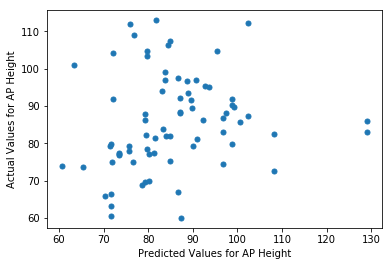

In [25]:
plot_prediction_quality(lm,df_predictors,df[target]);

## Is the Lasso any better?

In [23]:
# Initialize the classification algorithm (Random Forest Classification)
lm = Lasso(alpha=0.1, normalize=True)
print("R = %.3f +/- %.3f" % prediction_quality(lm,df_predictors,df[target]))

R = 0.455 +/- 0.093


## And Random Forest?

In [24]:
# Initialize the classification algorithm (Random Forest Classification)
rfr = RandomForestRegressor(n_estimators=100)
print("R = %.3f +/- %.3f" % prediction_quality(rfr,df_predictors,df[target]))

R = 0.555 +/- 0.081


## What does R = 0.5 look like?

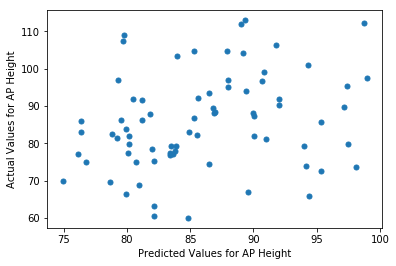

In [26]:
plot_prediction_quality(rfr,df_predictors,df[target]);

## Which features were important to the Random Forest model?

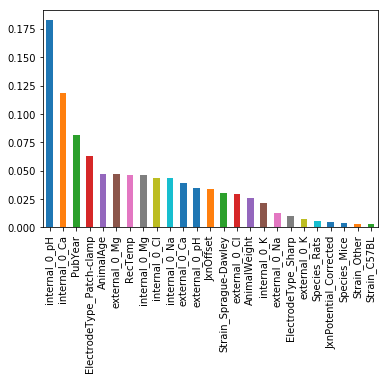

In [27]:
rfr.fit(df_predictors.values,df[target].values)
importances = pd.Series(rfr.feature_importances_,
                        index=list(df_predictors))
importances.sort_values(ascending=False)[:25].plot.bar();